In [1]:
# =========================================================
# AUTH & IMPORTS
# =========================================================
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# =========================================================
# LOAD DATA
# =========================================================
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet = gc.open_by_url(
    "INSERT_GOOGLE_SHEET_URL_HERE"
    )
sheet = spreadsheet.worksheet("Stage Deltas")
df = pd.DataFrame(sheet.get_all_records())

# =========================================================
# CLEAN DATA
# =========================================================
df = df.replace("-", pd.NA)

df["Meters"] = pd.to_numeric(df["Meters"], errors="coerce")
df = df.dropna(subset=["Meters"])

df["Material"] = df["Material"].astype(str).str.lower()

df["Material_Quartz"] = df["Material"].str.contains("quartz", na=False).astype(int)
df["Material_Porcelain"] = df["Material"].str.contains("porcelain", na=False).astype(int)
df["Material_NaturalStone"] = df["Material"].str.contains("natural|stone", na=False).astype(int)
df["Material_Ceramics"] = df["Material"].str.contains("ceramic", na=False).astype(int)

def yes_no(col):
    return col.astype(str).str.lower().map({"yes":1,"no":0}).fillna(0).astype(int)

df["CNC"] = yes_no(df["CNC"])
df["Waterjet"] = yes_no(df["Waterjet"])

stages = [
    "Measurements",
    "CAD",
    "Installation+Feedback",
    "CNC_Duration",
    "Waterjet_Duration",
    "Supplementary"
]

for s in stages:
    df[s] = pd.to_numeric(df[s], errors="coerce")

df = df[~df[stages].gt(24).any(axis=1)] # Remove outliers (data errors)

# =========================================================
# FEATURE ENGINEERING
# =========================================================
df["Meters_S_Quartz"] = df["Meters"] * df["Material_Quartz"]
df["Meters_S_Porcelain"] = df["Meters"] * df["Material_Porcelain"]
df["Meters_S_NaturalStone"] = df["Meters"] * df["Material_NaturalStone"]
df["Meters_S_Ceramics"] = df["Meters"] * df["Material_Ceramics"]

material_features = [
    "Material_Quartz",
    "Material_Porcelain",
    "Material_NaturalStone",
    "Material_Ceramics"
]

interaction_features = [
    "Meters_S_Quartz",
    "Meters_S_Porcelain",
    "Meters_S_NaturalStone",
    "Meters_S_Ceramics"
]

# =========================================================
# STATISTICAL STAGES
# =========================================================
stat_stages = ["Measurements", "Installation+Feedback"]

stat_models = {}
for stage in stat_stages:
    stat_models[stage] = df[stage].median()

# =========================================================
# ML STAGES
# =========================================================
ml_stage_features = {
    "CAD": ["Meters"] + material_features,
    "CNC_Duration": ["Meters"] + material_features + interaction_features,
    "Waterjet_Duration": ["Meters"] + material_features + interaction_features,
    "Supplementary": ["Meters"] + material_features + ["CNC", "Waterjet"]
}

ml_models = {}
ml_rmse = {}

for stage, feats in ml_stage_features.items():
    X = df[feats]
    y = df[stage].fillna(0)

    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=12,
        min_samples_leaf=3,
        random_state=42
    )

    y_pred_cv = cross_val_predict(model, X, y, cv=5)
    rmse = np.sqrt(mean_squared_error(y, y_pred_cv))

    model.fit(X, y)

    ml_models[stage] = model
    ml_rmse[stage] = rmse

# =========================================================
# PRINT RMS Error
# =========================================================
print("\nRMS error per ML stage (hours):")
for k, v in ml_rmse.items():
    print(f"{k:18s}: {v:.2f}")

print("\nAverage ML RMS error:", round(np.mean(list(ml_rmse.values())), 2))

# =========================================================
# PREDICT NEW JOB
# =========================================================
new_job = pd.DataFrame([{
    "Meters": 10,
    "Material_Quartz": 1,
    "Material_Porcelain": 0,
    "Material_NaturalStone": 0,
    "Material_Ceramics": 0,
    "CNC": 1,
    "Waterjet": 1
}])

for col in interaction_features:
    mat = col.replace("Meters_S_", "Material_")
    new_job[col] = new_job["Meters"] * new_job[mat]

# =========================================================
# FINAL PREDICTION
# =========================================================
predicted = {}

# Statistical predictions
for stage in stat_stages:
    predicted[stage] = stat_models[stage]

# ML predictions
for stage, model in ml_models.items():
    feats = ml_stage_features[stage]
    predicted[stage] = model.predict(new_job[feats])[0]

total_duration = sum(predicted.values())

print("\nPredicted duration per stage (hours):")
for k, v in predicted.items():
    print(f"{k:18s}: {v:.2f}")

print("\nTOTAL PREDICTED DURATION (hours):", round(total_duration, 2))



RMS error per ML stage (hours):
CAD               : 5.28
CNC_Duration      : 6.90
Waterjet_Duration : 4.26
Supplementary     : 5.49

Average ML RMS error: 5.48

Predicted duration per stage (hours):
Measurements      : 0.00
Installation+Feedback: 0.00
CAD               : 7.18
CNC_Duration      : 6.03
Waterjet_Duration : 4.13
Supplementary     : 7.53

TOTAL PREDICTED DURATION (hours): 24.87



Material: Quartz

--- Stage RMS errors ---

CAD (meters ≥ 3.0 m)
  Min Sigma(RMS error): 2.39 h at 3.92 m
  Max Sigma(RMS error): 11.18 h at 6.33 m

CNC_Duration (meters ≥ 3.0 m)
  Min Sigma(RMS error): 2.19 h at 10.75 m
  Max Sigma(RMS error): 6.31 h at 4.72 m

Waterjet_Duration (meters ≥ 3.0 m)
  Min Sigma(RMS error): 1.01 h at 4.32 m
  Max Sigma(RMS error): 7.92 h at 12.76 m

Supplementary (meters ≥ 3.0 m)
  Min Sigma(RMS error): 0.53 h at 10.35 m
  Max Sigma(RMS error): 10.51 h at 8.74 m

--- TOTAL RMS error ---

TOTAL (meters ≥ 3.0 m)
  Min Sigma(RMS error): 8.44 h at 10.35 m
  Max Sigma(RMS error): 15.42 h at 6.33 m


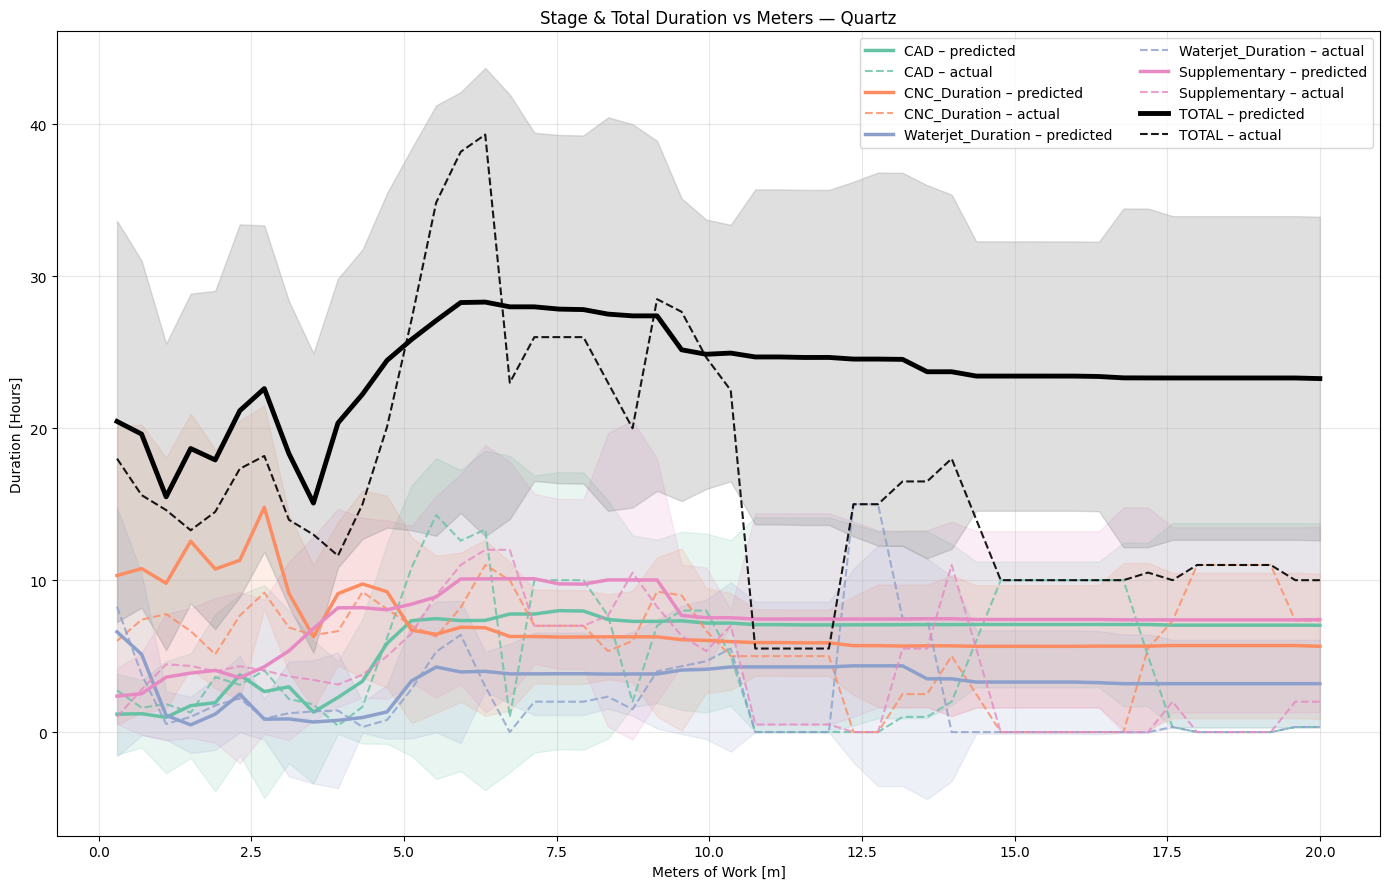


Material: Porcelain

--- Stage RMS errors ---

CAD (meters ≥ 3.0 m)
  Min Sigma(RMS error): 4.80 h at 14.37 m
  Max Sigma(RMS error): 9.81 h at 4.32 m

CNC_Duration (meters ≥ 3.0 m)
  Min Sigma(RMS error): 4.19 h at 5.93 m
  Max Sigma(RMS error): 8.74 h at 13.97 m

Waterjet_Duration (meters ≥ 3.0 m)
  Min Sigma(RMS error): 1.61 h at 6.33 m
  Max Sigma(RMS error): 7.53 h at 12.76 m

Supplementary (meters ≥ 3.0 m)
  Min Sigma(RMS error): 0.08 h at 10.35 m
  Max Sigma(RMS error): 10.53 h at 8.74 m

--- TOTAL RMS error ---

TOTAL (meters ≥ 3.0 m)
  Min Sigma(RMS error): 9.51 h at 9.95 m
  Max Sigma(RMS error): 14.58 h at 12.76 m


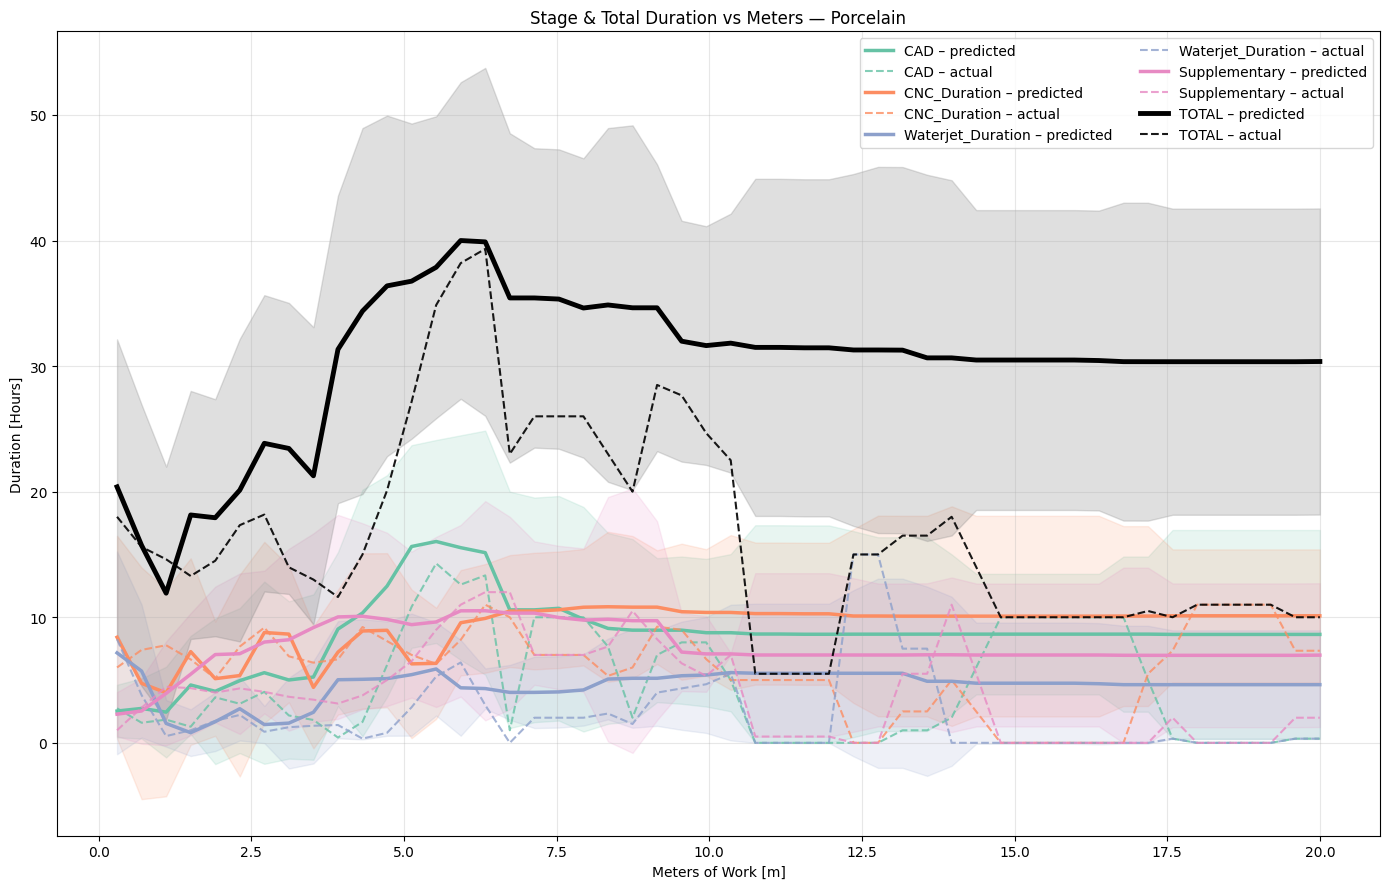

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# -------------------------------------------------
# Meter grid from real data
# -------------------------------------------------
meter_grid = np.linspace(df["Meters"].min(), 20, 50)

# -------------------------------------------------
# Safe job builder
# -------------------------------------------------
def build_job_df(meters, base_job):
    row = {"Meters": meters, **base_job}
    for col in interaction_features:
        mat = col.replace("Meters_S_", "Material_")
        row[col] = meters * row.get(mat, 0)
    return pd.DataFrame([row])

# -------------------------------------------------
# Actual mean by meter
# -------------------------------------------------
def actual_mean_by_meter(stage, meter_grid, max_window=3.0):
    means = []
    for m in meter_grid:
        val = np.nan
        for w in np.linspace(0.5, max_window, 6):
            mask = (df["Meters"] >= m - w) & (df["Meters"] <= m + w)
            vals = df.loc[mask, stage].dropna()
            if len(vals) > 0:
                val = vals.mean()
                break
        means.append(val)
    return np.array(means)

# -------------------------------------------------
# RMS error by meter
# -------------------------------------------------
def rmse_by_meter(stage, meter_grid, model, feats, base_job, max_window=3.0):
    rmses = []
    for m in meter_grid:
        rmse_val = np.nan
        for w in np.linspace(0.5, max_window, 6):
            mask = (df["Meters"] >= m - w) & (df["Meters"] <= m + w)
            vals = df.loc[mask, stage].dropna()
            if len(vals) >= 2:
                preds = []
                for mm in df.loc[mask, "Meters"]:
                    job = build_job_df(mm, base_job)
                    preds.append(model.predict(job[feats])[0])
                rmse_val = np.sqrt(np.mean((vals.values - np.array(preds)) ** 2))
                break
        rmses.append(rmse_val)
    return np.array(rmses)

# -------------------------------------------------
# Materials to plot
# -------------------------------------------------
materials = {
    "Quartz": {
        "Material_Quartz": 1,
        "Material_Porcelain": 0,
        "Material_NaturalStone": 0,
        "Material_Ceramics": 0,
        "CNC": 1,
        "Waterjet": 1
    },
    "Porcelain": {
        "Material_Quartz": 0,
        "Material_Porcelain": 1,
        "Material_NaturalStone": 0,
        "Material_Ceramics": 0,
        "CNC": 1,
        "Waterjet": 1
    }
}

def print_sigma_extremes(meter_grid, sigma, label, min_meter=3.0): #Above 3 meter = kitchen & major marble works
    meter_grid = np.array(meter_grid)
    sigma = np.array(sigma)

    # Filter: only meters >= min_meter
    valid = (~np.isnan(sigma)) & (meter_grid >= min_meter)

    if valid.sum() == 0:
        print(f"{label}: no valid sigma values above {min_meter} m")
        return

    filt_sigma = sigma[valid]
    filt_meter = meter_grid[valid]

    min_idx = np.argmin(filt_sigma)
    max_idx = np.argmax(filt_sigma)

    print(f"\n{label} (meters ≥ {min_meter} m)")
    print(f"  Min Sigma(RMS error): {filt_sigma[min_idx]:.2f} h at {filt_meter[min_idx]:.2f} m")
    print(f"  Max Sigma(RMS error): {filt_sigma[max_idx]:.2f} h at {filt_meter[max_idx]:.2f} m")

# -------------------------------------------------
# Color palette
# -------------------------------------------------
colors = cm.Set2.colors

for material_name, BASE_JOB in materials.items():

    print(f"\n==============================")
    print(f"Material: {material_name}")
    print(f"==============================")

    plt.figure(figsize=(14, 9))

    total_pred = np.zeros(len(meter_grid))
    total_actual = np.zeros(len(meter_grid))
    total_rmse_sq = np.zeros(len(meter_grid))

    stage_rmse_store = {}

    for i, stage in enumerate(ml_models.keys()):
        model = ml_models[stage]
        feats = ml_stage_features[stage]
        color = colors[i % len(colors)]

        # -----------------------------
        # Prediction
        # -----------------------------
        preds = []
        for m in meter_grid:
            job = build_job_df(m, BASE_JOB)
            preds.append(model.predict(job[feats])[0])
        preds = np.array(preds)

        # -----------------------------
        # Actual + RMS error
        # -----------------------------
        actual = actual_mean_by_meter(stage, meter_grid)
        rmse = rmse_by_meter(stage, meter_grid, model, feats, BASE_JOB)

        stage_rmse_store[stage] = rmse

        total_pred += preds
        total_actual += np.nan_to_num(actual)
        total_rmse_sq += np.nan_to_num(rmse) ** 2

        # -----------------------------
        # Plot stage
        # -----------------------------
        plt.plot(
            meter_grid, preds,
            color=color, linewidth=2.5,
            label=f"{stage} – predicted"
        )
        plt.plot(
            meter_grid, actual,
            color=color, linestyle="--",
            alpha=0.8,
            label=f"{stage} – actual"
        )
        plt.fill_between(
            meter_grid,
            preds - rmse,
            preds + rmse,
            color=color,
            alpha=0.15
        )

    # -------------------------------------------------
    # TOTAL
    # -------------------------------------------------
    for s in stat_stages:
        total_pred += stat_models[s]
        total_actual += stat_models[s]

    total_rmse = np.sqrt(total_rmse_sq)

    plt.plot(
        meter_grid, total_pred,
        color="black", linewidth=3.5,
        label="TOTAL – predicted"
    )
    plt.plot(
        meter_grid, total_actual,
        color="black", linestyle="--",
        alpha=0.9,
        label="TOTAL – actual"
    )
    plt.fill_between(
        meter_grid,
        total_pred - total_rmse,
        total_pred + total_rmse,
        color="gray",
        alpha=0.25
    )

    # -------------------------------------------------
    # PRINT SIGMA (RMS error per meter)
    # -------------------------------------------------
    print("\n--- Stage RMS errors ---")
    for stage, rmse in stage_rmse_store.items():
        print_sigma_extremes(meter_grid, rmse, stage)

    print("\n--- TOTAL RMS error ---")
    print_sigma_extremes(meter_grid, total_rmse, "TOTAL")

    # -------------------------------------------------
    # FINAL DECORATION
    # -------------------------------------------------
    plt.xlabel("Meters of Work [m]")
    plt.ylabel("Duration [Hours]")
    plt.title(f"Stage & Total Duration vs Meters — {material_name}")
    plt.legend(ncol=2)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

